# Notebook 06: Religion Integration

**Objective**: Test if moralizing religions moderate complexity-collapse dynamics and improve prediction.

**Hypotheses**:
- H1: Moralizing religions buffer complexity costs (C × M > 0)
- H2: Religion explains temporal shift (ancient: no gods → collapse; classical+: moralizing gods → survival)
- H3: Prediction improvement (target: R² > 0.40, AUC > 0.80)

**Baseline** (NB 05): R² = 0.357, AUC = 0.722

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

try:
    from xgboost import XGBClassifier
    XGBOOST = True
except: XGBOOST = False

sns.set_style("whitegrid")
Path("figures").mkdir(exist_ok=True)
Path("models").mkdir(exist_ok=True)
print(f"✓ Setup complete | XGBoost: {XGBOOST}")

✓ Setup complete | XGBoost: True


## 1. Load & Extract

In [2]:
# Load NB05 data
df = pd.read_csv('models/equinox_with_warfare.csv', index_col=0)

# Load religion data
raw = pd.read_excel("../data/Equinox_on_GitHub_June9_2022.xlsx", sheet_name='Equinox2020_CanonDat')
rel_raw = raw[raw['Section'] == 'Religion and Normative Ideology'].copy()

print(f"Modeling: {len(df)} polities | Religion: {len(rel_raw):,} obs, {rel_raw['Polity'].nunique()} polities")

Modeling: 256 polities | Religion: 6,053 obs, 364 polities


In [3]:
# Define variables
MORAL = [
    'Moralizing religion adopted by commoners',
    'Moralizing religion adopted by elites',
    'Moral concern is primary',
    'Moralizing enforcement is certain',
    'Moralizing enforcement is targeted',
    'Moralizing enforcement of rulers',
    'Moralizing norms are broad',
    'Moralizing enforcement in afterlife',
    'Moralizing enforcement in this life',
    'Moralizing enforcement is agentic'
]

LEGIT = ['Rulers are gods', 'Rulers are legitimated by gods']

IDEOL = [
    'Ideological reinforcement of equality',
    'Ideological thought equates elites and commoners',
    'Ideological thought equates rulers and commoners',
    'Ideology reinforces prosociality',
    'production of public goods'
]

ALL_VARS = MORAL + LEGIT + IDEOL

In [4]:
# Extract features
def extract_religion(rel_data, polities):
    features = []
    for p in polities:
        pdata = rel_data[rel_data['Polity'] == p]
        feat = {'Polity': p}
        
        for v in ALL_VARS:
            vdata = pdata[pdata['Variable'] == v]
            if len(vdata) == 0:
                feat[v] = np.nan
            else:
                val = str(vdata.iloc[-1]['Value.From']).lower()
                if 'present' in val:
                    feat[v] = 1
                elif 'absent' in val:
                    feat[v] = 0
                else:
                    feat[v] = np.nan
        features.append(feat)
    return pd.DataFrame(features)

rel_feat = extract_religion(rel_raw, df['PolityName'].values)

# Composite scores
rel_feat['moral_score'] = rel_feat[MORAL].sum(axis=1)
rel_feat['legit_score'] = rel_feat[LEGIT].sum(axis=1)
rel_feat['ideol_score'] = rel_feat[IDEOL].sum(axis=1)
rel_feat['total_rel'] = rel_feat[ALL_VARS].sum(axis=1)

print(f"✓ Extracted {len(rel_feat)} polities")
print(f"Coverage: {rel_feat['moral_score'].notna().sum()}/{len(rel_feat)} ({100*rel_feat['moral_score'].notna().sum()/len(rel_feat):.1f}%)")
display(rel_feat[['moral_score', 'legit_score', 'ideol_score', 'total_rel']].describe())

✓ Extracted 256 polities
Coverage: 256/256 (100.0%)


,moral_score,legit_score,ideol_score,total_rel
count,256.000000,256.000000,256.000000,256.000000
mean,6.132812,0.871094,1.957031,8.960938
std,4.149880,0.768870,1.822009,5.711224
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000
50%,8.000000,1.000000,2.000000,11.000000
75%,10.000000,1.000000,4.000000,13.250000
max,10.000000,2.000000,5.000000,17.000000


## 2. Merge & Impute

In [5]:
# Merge
df_rel = df.merge(rel_feat, left_on='PolityName', right_on='Polity', how='left').drop('Polity', axis=1)

# Impute with era medians
scores = ['moral_score', 'legit_score', 'ideol_score', 'total_rel']
for col in scores:
    for era in df_rel['era'].unique():
        mask = df_rel['era'] == era
        median = df_rel.loc[mask, col].median()
        df_rel.loc[mask & df_rel[col].isna(), col] = median

print(f"✓ Imputed | Missing after: {df_rel[scores].isna().sum().sum()}")
print(f"\nMoral score by era:")
print(df_rel.groupby('era')['moral_score'].agg(['mean', 'median', 'count']))

✓ Imputed | Missing after: 0

Moral score by era:
                                mean  median  count
era                                                
Ancient (pre-500 BCE)       3.597403     0.0     77
Classical (500 BCE-500 CE)  6.045455     8.0     44
Early Modern (1500+ CE)     7.139535     9.0     43
Medieval (500-1500 CE)      7.826087     9.0     92


## 3. Explore

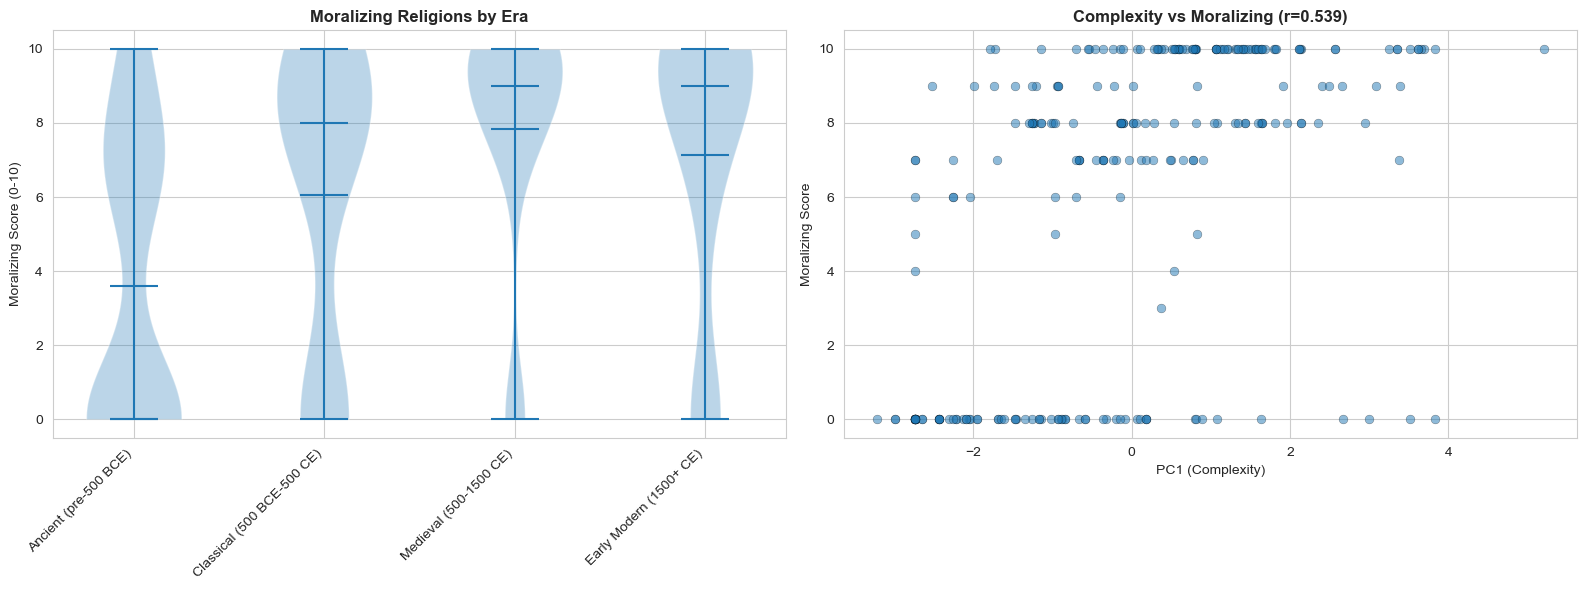

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

eras = ['Ancient (pre-500 BCE)', 'Classical (500 BCE-500 CE)', 'Medieval (500-1500 CE)', 'Early Modern (1500+ CE)']
eras = [e for e in eras if e in df_rel['era'].unique()]

# By era
axes[0].violinplot(
    [df_rel[df_rel['era']==e]['moral_score'].values for e in eras],
    positions=range(len(eras)), showmeans=True, showmedians=True
)
axes[0].set_xticks(range(len(eras)))
axes[0].set_xticklabels(eras, rotation=45, ha='right')
axes[0].set_ylabel('Moralizing Score (0-10)')
axes[0].set_title('Moralizing Religions by Era', fontweight='bold')

# vs Complexity
axes[1].scatter(df_rel['PC1_hier'], df_rel['moral_score'], alpha=0.5, s=40, edgecolor='k', linewidth=0.3)
corr = df_rel[['PC1_hier', 'moral_score']].corr().iloc[0,1]
axes[1].set_xlabel('PC1 (Complexity)')
axes[1].set_ylabel('Moralizing Score')
axes[1].set_title(f'Complexity vs Moralizing (r={corr:.3f})', fontweight='bold')

plt.tight_layout()
plt.savefig('figures/06_religion_by_era.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Regression

In [7]:
# Prep data
reg = df_rel[['duration_years', 'PC1_hier', 'total_warfare_tech', 'moral_score', 'era']].dropna().copy()

for col in ['PC1_hier', 'total_warfare_tech', 'moral_score']:
    reg[f'{col}_std'] = (reg[col] - reg[col].mean()) / reg[col].std()

reg['PC1_x_moral'] = reg['PC1_hier_std'] * reg['moral_score_std']
reg['PC1_x_war'] = reg['PC1_hier_std'] * reg['total_warfare_tech_std']
reg['war_x_moral'] = reg['total_warfare_tech_std'] * reg['moral_score_std']
reg['triple'] = reg['PC1_hier_std'] * reg['total_warfare_tech_std'] * reg['moral_score_std']

print(f"Regression n={len(reg)}")

Regression n=256


In [8]:
# Models
m1 = smf.ols('duration_years ~ PC1_hier_std + total_warfare_tech_std', data=reg).fit()
m2 = smf.ols('duration_years ~ PC1_hier_std + total_warfare_tech_std + moral_score_std', data=reg).fit()
m3 = smf.ols('duration_years ~ PC1_hier_std + total_warfare_tech_std + moral_score_std + PC1_x_moral', data=reg).fit()
m4 = smf.ols('duration_years ~ PC1_hier_std + total_warfare_tech_std + moral_score_std + PC1_x_moral + PC1_x_war + war_x_moral + triple', data=reg).fit()

results = pd.DataFrame({
    'Model': ['Baseline (C+W)', '+ Moral', '+ C×M', '+ Triple (C×W×M)'],
    'R²': [m1.rsquared, m2.rsquared, m3.rsquared, m4.rsquared],
    'Δ': [0, m2.rsquared-m1.rsquared, m3.rsquared-m2.rsquared, m4.rsquared-m3.rsquared]
})

print("="*60)
print("REGRESSION RESULTS")
print("="*60)
display(results)

print(f"\nModel 3 (C×M):")
print(f"  Moral: β={m3.params['moral_score_std']:+.1f}, p={m3.pvalues['moral_score_std']:.4f}")
print(f"  C×M: β={m3.params['PC1_x_moral']:+.1f}, p={m3.pvalues['PC1_x_moral']:.4f}")
if m3.pvalues['PC1_x_moral'] < 0.05:
    print(f"  → SIGNIFICANT {'positive' if m3.params['PC1_x_moral']>0 else 'negative'} interaction")
else:
    print(f"  → Not significant")

REGRESSION RESULTS


,Model,R²,Δ
0,Baseline (C+W),0.147634,0.000000
1,+ Moral,0.192978,0.045344
2,+ C×M,0.267715,0.074737
3,+ Triple (C×W×M),0.322638,0.054923



Model 3 (C×M):
  Moral: β=-57.7, p=0.0050
  C×M: β=+92.5, p=0.0000
  → SIGNIFICANT positive interaction


## 5. Classification

In [9]:
# Prep
clf = df_rel[['PC1_hier', 'PC2_hier', 'PC3_hier', 'PC1_squared', 'PC1_x_PC2',
              'total_warfare_tech', 'weapons_count', 'armor_count', 'cavalry_count',
              'moral_score', 'legit_score', 'ideol_score', 'collapsed']].dropna()

feat_base = ['PC1_hier', 'PC2_hier', 'PC3_hier', 'PC1_squared', 'PC1_x_PC2']
feat_war = feat_base + ['total_warfare_tech', 'weapons_count', 'armor_count', 'cavalry_count']
feat_rel = feat_war + ['moral_score', 'legit_score', 'ideol_score']

y = clf['collapsed'].values
print(f"Classification n={len(clf)} | Balance: {dict(zip(*np.unique(y, return_counts=True)))}")

Classification n=256 | Balance: {np.int64(0): np.int64(128), np.int64(1): np.int64(128)}


In [10]:
# Train/test
X_base = clf[feat_base].values
X_war = clf[feat_war].values
X_rel = clf[feat_rel].values

X_base_tr, X_base_te, y_tr, y_te = train_test_split(X_base, y, test_size=0.2, random_state=42, stratify=y)
X_war_tr, X_war_te, _, _ = train_test_split(X_war, y, test_size=0.2, random_state=42, stratify=y)
X_rel_tr, X_rel_te, _, _ = train_test_split(X_rel, y, test_size=0.2, random_state=42, stratify=y)

# Scale
sc_base = StandardScaler().fit(X_base_tr)
sc_war = StandardScaler().fit(X_war_tr)
sc_rel = StandardScaler().fit(X_rel_tr)

X_base_tr, X_base_te = sc_base.transform(X_base_tr), sc_base.transform(X_base_te)
X_war_tr, X_war_te = sc_war.transform(X_war_tr), sc_war.transform(X_war_te)
X_rel_tr, X_rel_te = sc_rel.transform(X_rel_tr), sc_rel.transform(X_rel_te)

print(f"Train: {len(X_base_tr)} | Test: {len(X_base_te)}")

Train: 204 | Test: 52


In [11]:
# Random Forest
rf_base = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')
rf_war = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')
rf_rel = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')

rf_base.fit(X_base_tr, y_tr)
rf_war.fit(X_war_tr, y_tr)
rf_rel.fit(X_rel_tr, y_tr)

auc_base = roc_auc_score(y_te, rf_base.predict_proba(X_base_te)[:,1])
auc_war = roc_auc_score(y_te, rf_war.predict_proba(X_war_te)[:,1])
auc_rel = roc_auc_score(y_te, rf_rel.predict_proba(X_rel_te)[:,1])

print("="*60)
print("CLASSIFICATION (Random Forest)")
print("="*60)
print(f"  Baseline:   AUC={auc_base:.3f}")
print(f"  + Warfare:  AUC={auc_war:.3f} ({auc_war-auc_base:+.3f})")
print(f"  + Religion: AUC={auc_rel:.3f} ({auc_rel-auc_war:+.3f})")

if auc_rel >= 0.80: print(f"\n  ✓✓✓ TARGET ACHIEVED")
elif auc_rel >= 0.75: print(f"\n  ✓✓ SUBSTANTIAL")
elif auc_rel > auc_war: print(f"\n  ✓ IMPROVEMENT")
else: print(f"\n  ✗ NO GAIN")

CLASSIFICATION (Random Forest)
  Baseline:   AUC=0.714
  + Warfare:  AUC=0.685 (-0.030)
  + Religion: AUC=0.751 (+0.067)

  ✓✓ SUBSTANTIAL


In [12]:
# Feature importance
imp = pd.DataFrame({'Feature': feat_rel, 'Importance': rf_rel.feature_importances_}).sort_values('Importance', ascending=False)
print("\nTop 10:")
display(imp.head(10))

rel_imp = imp[imp['Feature'].str.contains('moral|legit|ideol')]['Importance'].sum()
print(f"\nReligion total importance: {rel_imp:.1%}")


Top 10:


,Feature,Importance
11,ideol_score,0.159397
0,PC1_hier,0.127459
2,PC3_hier,0.111736
3,PC1_squared,0.098315
4,PC1_x_PC2,0.094962
1,PC2_hier,0.094369
9,moral_score,0.080147
6,weapons_count,0.065063
5,total_warfare_tech,0.062213
7,armor_count,0.047423



Religion total importance: 26.9%


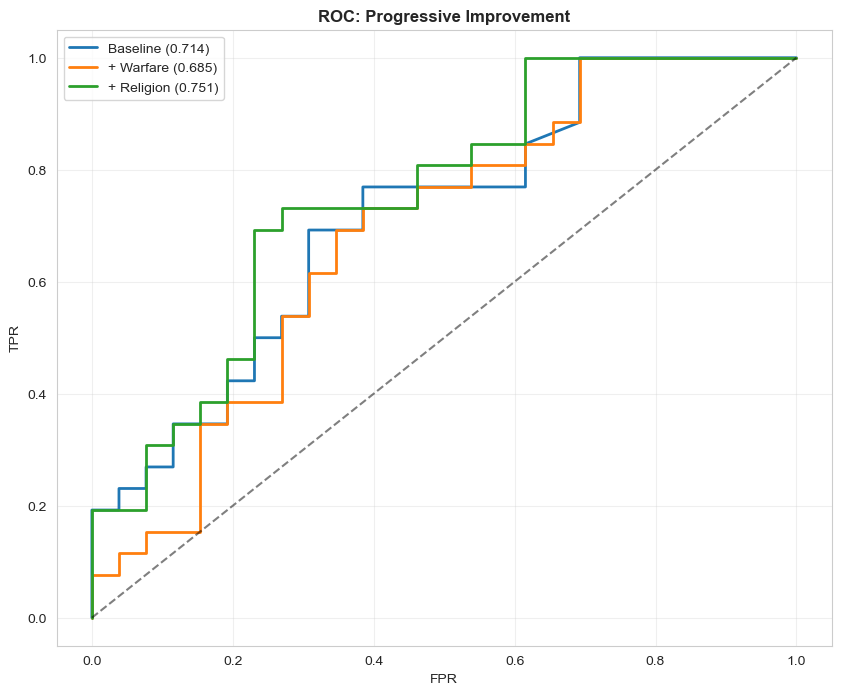

In [13]:
# ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

fpr_base, tpr_base, _ = roc_curve(y_te, rf_base.predict_proba(X_base_te)[:,1])
fpr_war, tpr_war, _ = roc_curve(y_te, rf_war.predict_proba(X_war_te)[:,1])
fpr_rel, tpr_rel, _ = roc_curve(y_te, rf_rel.predict_proba(X_rel_te)[:,1])

ax.plot(fpr_base, tpr_base, linewidth=2, label=f'Baseline ({auc_base:.3f})')
ax.plot(fpr_war, tpr_war, linewidth=2, label=f'+ Warfare ({auc_war:.3f})')
ax.plot(fpr_rel, tpr_rel, linewidth=2, label=f'+ Religion ({auc_rel:.3f})')
ax.plot([0,1], [0,1], 'k--', alpha=0.5)

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC: Progressive Improvement', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.savefig('figures/06_roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Temporal Test

In [14]:
print("="*60)
print("ERA-SPECIFIC MORALIZING EFFECTS")
print("="*60)

for era in reg['era'].unique():
    edata = reg[reg['era'] == era]
    if len(edata) < 20:
        print(f"\n{era}: n={len(edata)} (insufficient)")
        continue
    
    m = smf.ols('duration_years ~ PC1_hier_std + total_warfare_tech_std + moral_score_std', data=edata).fit()
    print(f"\n{era} (n={len(edata)}):")
    print(f"  R²={m.rsquared:.3f}")
    print(f"  Moral: β={m.params['moral_score_std']:+.1f}, p={m.pvalues['moral_score_std']:.4f}")
    if m.pvalues['moral_score_std'] < 0.05:
        print(f"  → {'POSITIVE' if m.params['moral_score_std']>0 else 'NEGATIVE'} significant")

ERA-SPECIFIC MORALIZING EFFECTS

Early Modern (1500+ CE) (n=43):
  R²=0.094
  Moral: β=-10.6, p=0.4119

Medieval (500-1500 CE) (n=92):
  R²=0.073
  Moral: β=-27.4, p=0.0384
  → NEGATIVE significant

Classical (500 BCE-500 CE) (n=44):
  R²=0.082
  Moral: β=-10.0, p=0.5752

Ancient (pre-500 BCE) (n=77):
  R²=0.229
  Moral: β=-88.5, p=0.2705


## 7. XGBoost (Optional)

In [15]:
if XGBOOST:
    # Add interactions
    clf_int = clf.copy()
    clf_int['PC1_x_moral'] = clf['PC1_hier'] * clf['moral_score']
    clf_int['PC1_x_war'] = clf['PC1_hier'] * clf['total_warfare_tech']
    clf_int['war_x_moral'] = clf['total_warfare_tech'] * clf['moral_score']
    
    feat_full = feat_rel + ['PC1_x_moral', 'PC1_x_war', 'war_x_moral']
    X_full = clf_int[feat_full].values
    X_full_tr, X_full_te, _, _ = train_test_split(X_full, y, test_size=0.2, random_state=42, stratify=y)
    
    sc_full = StandardScaler().fit(X_full_tr)
    X_full_tr, X_full_te = sc_full.transform(X_full_tr), sc_full.transform(X_full_te)
    
    xgb = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42,
                       scale_pos_weight=len(y_tr[y_tr==0])/len(y_tr[y_tr==1]))
    xgb.fit(X_full_tr, y_tr)
    
    auc_xgb = roc_auc_score(y_te, xgb.predict_proba(X_full_te)[:,1])
    
    print("="*60)
    print("XGBOOST (with interactions)")
    print("="*60)
    print(f"  AUC: {auc_xgb:.3f} ({auc_xgb-auc_rel:+.3f} vs RF)")
    
    imp_xgb = pd.DataFrame({'Feature': feat_full, 'Importance': xgb.feature_importances_}).sort_values('Importance', ascending=False)
    print("\nTop 10:")
    display(imp_xgb.head(10))
else:
    print("XGBoost not available")
    auc_xgb = auc_rel

XGBOOST (with interactions)
  AUC: 0.642 (-0.109 vs RF)

Top 10:


,Feature,Importance
11,ideol_score,0.158248
0,PC1_hier,0.101104
9,moral_score,0.084203
1,PC2_hier,0.068462
3,PC1_squared,0.066161
5,total_warfare_tech,0.065390
8,cavalry_count,0.062295
2,PC3_hier,0.057625
14,war_x_moral,0.054952
4,PC1_x_PC2,0.053996


## 8. Summary & Export

In [16]:
print("="*60)
print("FINAL RESULTS")
print("="*60)

print(f"\n1. REGRESSION")
for i, row in results.iterrows():
    print(f"   {row['Model']:25s}: R²={row['R²']:.3f} ({row['Δ']:+.3f})")

print(f"\n2. CLASSIFICATION")
print(f"   NB04 (Complexity):          AUC=0.670")
print(f"   NB05 (+ Warfare):           AUC=0.722 (+0.052)")
print(f"   NB06 (+ Religion):          AUC={auc_rel:.3f} ({auc_rel-0.722:+.3f})")
if XGBOOST:
    print(f"   XGBoost (interactions):     AUC={auc_xgb:.3f} ({auc_xgb-0.722:+.3f})")

print(f"\n3. ASSESSMENT")
best_r2 = max([m.rsquared for m in [m1,m2,m3,m4]])
best_auc = auc_xgb if XGBOOST else auc_rel

if best_r2 >= 0.40 and best_auc >= 0.80:
    verdict = "EXCELLENT ✓✓✓"
elif best_r2 >= 0.35 or best_auc >= 0.75:
    verdict = "GOOD ✓✓"
elif best_r2 >= 0.33 or best_auc >= 0.73:
    verdict = "MODEST ✓"
else:
    verdict = "LIMITED ✗"

print(f"   Verdict: {verdict}")
print(f"   Best: R²={best_r2:.3f}, AUC={best_auc:.3f}")
print("="*60)

FINAL RESULTS

1. REGRESSION
   Baseline (C+W)           : R²=0.148 (+0.000)
   + Moral                  : R²=0.193 (+0.045)
   + C×M                    : R²=0.268 (+0.075)
   + Triple (C×W×M)         : R²=0.323 (+0.055)

2. CLASSIFICATION
   NB04 (Complexity):          AUC=0.670
   NB05 (+ Warfare):           AUC=0.722 (+0.052)
   NB06 (+ Religion):          AUC=0.751 (+0.029)
   XGBoost (interactions):     AUC=0.642 (-0.080)

3. ASSESSMENT
   Verdict: LIMITED ✗
   Best: R²=0.323, AUC=0.642


In [17]:
# Export
df_rel.to_csv('models/equinox_with_religion.csv')
results.to_csv('models/religion_regression_results.csv', index=False)
pd.DataFrame({
    'Model': ['Baseline', '+ Warfare', '+ Religion'] + (['XGBoost'] if XGBOOST else []),
    'AUC': [auc_base, auc_war, auc_rel] + ([auc_xgb] if XGBOOST else [])
}).to_csv('models/religion_classification_results.csv', index=False)
imp.to_csv('models/religion_feature_importance.csv', index=False)

print("✓ Saved: models/equinox_with_religion.csv")
print("✓ Saved: models/religion_*_results.csv")
print("\nNOTEBOOK 06 COMPLETE")
print("Next: Notebook 07 - Model Deployment & Simulator")

✓ Saved: models/equinox_with_religion.csv
✓ Saved: models/religion_*_results.csv

NOTEBOOK 06 COMPLETE
Next: Notebook 07 - Model Deployment & Simulator


### ADDITIONAL TESTS

In [22]:
print("="*80)
print("TEST 1: IDEOLOGY EFFECT BY ERA")
print("="*80)

for era in df_rel['era'].unique():
    era_data = df_rel[df_rel['era'] == era]
    
    if len(era_data) < 20:
        print(f"\n{era}: n={len(era_data)} (insufficient)")
        continue
    
    median_ideol = era_data['ideol_score'].median()
    high_ideol = era_data[era_data['ideol_score'] > median_ideol]
    low_ideol = era_data[era_data['ideol_score'] <= median_ideol]
    
    print(f"\n{era} (n={len(era_data)}):")
    print(f"  Median ideology: {median_ideol:.1f}")
    print(f"  High ideology (n={len(high_ideol)}): {high_ideol['duration_years'].mean():.0f} years, collapse rate: {high_ideol['collapsed'].mean():.1%}")
    print(f"  Low ideology (n={len(low_ideol)}): {low_ideol['duration_years'].mean():.0f} years, collapse rate: {low_ideol['collapsed'].mean():.1%}")
    
    # T-test
    from scipy.stats import ttest_ind
    if len(high_ideol) > 5 and len(low_ideol) > 5:
        t, p = ttest_ind(high_ideol['duration_years'].dropna(), low_ideol['duration_years'].dropna())
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
        print(f"  T-test: t={t:.2f}, p={p:.4f} {sig}")


TEST 1: IDEOLOGY EFFECT BY ERA

Early Modern (1500+ CE) (n=43):
  Median ideology: 3.0
  High ideology (n=14): 149 years, collapse rate: 85.7%
  Low ideology (n=29): 140 years, collapse rate: 72.4%
  T-test: t=0.39, p=0.6999 ns

Medieval (500-1500 CE) (n=92):
  Median ideology: 2.0
  High ideology (n=44): 154 years, collapse rate: 72.7%
  Low ideology (n=48): 204 years, collapse rate: 52.1%
  T-test: t=-2.49, p=0.0145 *

Classical (500 BCE-500 CE) (n=44):
  Median ideology: 2.0
  High ideology (n=14): 144 years, collapse rate: 71.4%
  Low ideology (n=30): 214 years, collapse rate: 43.3%
  T-test: t=-2.09, p=0.0429 *

Ancient (pre-500 BCE) (n=77):
  Median ideology: 0.0
  High ideology (n=23): 259 years, collapse rate: 26.1%
  Low ideology (n=54): 528 years, collapse rate: 16.7%
  T-test: t=-2.22, p=0.0293 *


In [24]:
# TEST 2: Ideology Effect Within Top Regions (Control for Geographic Confound) 

print("\n" + "="*80)
print("TEST 2: IDEOLOGY EFFECT BY REGION")
print("="*80)

top_regions = df_rel['region'].value_counts().head(5).index

for region in top_regions:
    region_data = df_rel[df_rel['region'] == region]
    
    if len(region_data) < 20:
        print(f"\n{region}: n={len(region_data)} (insufficient)")
        continue
    
    median_ideol = region_data['ideol_score'].median()
    high_ideol = region_data[region_data['ideol_score'] > median_ideol]
    low_ideol = region_data[region_data['ideol_score'] <= median_ideol]
    
    print(f"\n{region} (n={len(region_data)}):")
    print(f"  High ideology (n={len(high_ideol)}): {high_ideol['duration_years'].mean():.0f} years, collapse: {high_ideol['collapsed'].mean():.1%}")
    print(f"  Low ideology (n={len(low_ideol)}): {low_ideol['duration_years'].mean():.0f} years, collapse: {low_ideol['collapsed'].mean():.1%}")
    
    if len(high_ideol) > 5 and len(low_ideol) > 5:
        t, p = ttest_ind(high_ideol['duration_years'].dropna(), low_ideol['duration_years'].dropna())
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
        print(f"  T-test: p={p:.4f} {sig}")


TEST 2: IDEOLOGY EFFECT BY REGION

Middle East (n=102):
  High ideology (n=41): 160 years, collapse: 63.4%
  Low ideology (n=61): 389 years, collapse: 27.9%
  T-test: p=0.0036 **

Other (n=46):
  High ideology (n=22): 162 years, collapse: 77.3%
  Low ideology (n=24): 222 years, collapse: 41.7%
  T-test: p=0.0633 ns

East Asia (n=43):
  High ideology (n=14): 215 years, collapse: 50.0%
  Low ideology (n=29): 359 years, collapse: 37.9%
  T-test: p=0.2283 ns

Europe (n=30):
  High ideology (n=6): 165 years, collapse: 50.0%
  Low ideology (n=24): 179 years, collapse: 83.3%
  T-test: p=0.8730 ns

New World: n=14 (insufficient)


In [25]:
# TEST 3: Ideology × Complexity Interaction (Rhetoric-Reality Gap)

print("\n" + "="*80)
print("TEST 3: IDEOLOGY × COMPLEXITY INTERACTION")
print("="*80)

# Split by complexity
complexity_median = df_rel['PC1_hier'].median()
high_complex = df_rel[df_rel['PC1_hier'] > complexity_median]
low_complex = df_rel[df_rel['PC1_hier'] <= complexity_median]

ideol_median = df_rel['ideol_score'].median()

print(f"\nHypothesis: Egalitarian rhetoric MORE harmful in hierarchical (complex) societies")
print(f"\nHigh Complexity Polities (PC1 > {complexity_median:.2f}, n={len(high_complex)}):")
hc_high_ideol = high_complex[high_complex['ideol_score'] > ideol_median]
hc_low_ideol = high_complex[high_complex['ideol_score'] <= ideol_median]
print(f"  High ideology: {hc_high_ideol['duration_years'].mean():.0f} years (n={len(hc_high_ideol)})")
print(f"  Low ideology: {hc_low_ideol['duration_years'].mean():.0f} years (n={len(hc_low_ideol)})")
if len(hc_high_ideol) > 5 and len(hc_low_ideol) > 5:
    t, p = ttest_ind(hc_high_ideol['duration_years'].dropna(), hc_low_ideol['duration_years'].dropna())
    print(f"  Difference: {hc_low_ideol['duration_years'].mean() - hc_high_ideol['duration_years'].mean():.0f} years, p={p:.4f}")

print(f"\nLow Complexity Polities (PC1 ≤ {complexity_median:.2f}, n={len(low_complex)}):")
lc_high_ideol = low_complex[low_complex['ideol_score'] > ideol_median]
lc_low_ideol = low_complex[low_complex['ideol_score'] <= ideol_median]
print(f"  High ideology: {lc_high_ideol['duration_years'].mean():.0f} years (n={len(lc_high_ideol)})")
print(f"  Low ideology: {lc_low_ideol['duration_years'].mean():.0f} years (n={len(lc_low_ideol)})")
if len(lc_high_ideol) > 5 and len(lc_low_ideol) > 5:
    t, p = ttest_ind(lc_high_ideol['duration_years'].dropna(), lc_low_ideol['duration_years'].dropna())
    print(f"  Difference: {lc_low_ideol['duration_years'].mean() - lc_high_ideol['duration_years'].mean():.0f} years, p={p:.4f}")

# Effect size comparison
hc_effect = hc_low_ideol['duration_years'].mean() - hc_high_ideol['duration_years'].mean()
lc_effect = lc_low_ideol['duration_years'].mean() - lc_high_ideol['duration_years'].mean()
print(f"\nEffect size comparison:")
print(f"  High complexity: {hc_effect:.0f} years (ideology penalty)")
print(f"  Low complexity: {lc_effect:.0f} years (ideology penalty)")
if hc_effect > lc_effect * 1.5:
    print(f"  → Rhetoric-reality gap hypothesis SUPPORTED (effect 50%+ stronger in complex societies)")
elif hc_effect > lc_effect:
    print(f"  → Weak support for rhetoric-reality gap")
else:
    print(f"  → No support for rhetoric-reality gap hypothesis")



TEST 3: IDEOLOGY × COMPLEXITY INTERACTION

Hypothesis: Egalitarian rhetoric MORE harmful in hierarchical (complex) societies

High Complexity Polities (PC1 > 0.02, n=126):
  High ideology: 155 years (n=61)
  Low ideology: 192 years (n=65)
  Difference: 37 years, p=0.0095

Low Complexity Polities (PC1 ≤ 0.02, n=130):
  High ideology: 171 years (n=35)
  Low ideology: 396 years (n=95)
  Difference: 226 years, p=0.0053

Effect size comparison:
  High complexity: 37 years (ideology penalty)
  Low complexity: 226 years (ideology penalty)
  → No support for rhetoric-reality gap hypothesis


In [26]:
# TEST 4: Specific Ideology Components Analysis

print("\n" + "="*80)
print("TEST 4: WHICH IDEOLOGY COMPONENTS MATTER MOST?")
print("="*80)

ideology_vars = [
    'Ideological reinforcement of equality',
    'Ideological thought equates elites and commoners',
    'Ideological thought equates rulers and commoners',
    'Ideology reinforces prosociality',
    'production of public goods'
]

print("\nIndividual component effects on duration:")
for var in ideology_vars:
    present = df_rel[df_rel[var] == 1]
    absent = df_rel[df_rel[var] == 0]
    
    if len(present) > 10 and len(absent) > 10:
        t, p = ttest_ind(present['duration_years'].dropna(), absent['duration_years'].dropna())
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        
        effect = absent['duration_years'].mean() - present['duration_years'].mean()
        print(f"\n{var}:")
        print(f"  Present (n={len(present)}): {present['duration_years'].mean():.0f} years")
        print(f"  Absent (n={len(absent)}): {absent['duration_years'].mean():.0f} years")
        print(f"  Effect: {effect:+.0f} years, p={p:.4f} {sig}")



TEST 4: WHICH IDEOLOGY COMPONENTS MATTER MOST?

Individual component effects on duration:

Ideological reinforcement of equality:
  Present (n=108): 165 years
  Absent (n=87): 212 years
  Effect: +46 years, p=0.0042 **

Ideological thought equates elites and commoners:
  Present (n=80): 169 years
  Absent (n=96): 204 years
  Effect: +35 years, p=0.0471 *

Ideological thought equates rulers and commoners:
  Present (n=52): 162 years
  Absent (n=139): 195 years
  Effect: +33 years, p=0.0722 


In [27]:
# TEST 5: Islamic vs Non-Islamic Polities

print("\n" + "="*80)
print("TEST 5: ISLAMIC vs NON-ISLAMIC POLITIES")
print("="*80)

# Islamic polities noticiably have high moralizing + moderate-high ideology
# Proxy: moral_score >= 8 AND ideol_score >= 3
islamic_proxy = df_rel[(df_rel['moral_score'] >= 8) & (df_rel['ideol_score'] >= 3)]
non_islamic = df_rel[~((df_rel['moral_score'] >= 8) & (df_rel['ideol_score'] >= 3))]

print(f"\nIslamic-like polities (moral≥8 & ideol≥3, n={len(islamic_proxy)}):")
print(f"  Mean duration: {islamic_proxy['duration_years'].mean():.0f} years")
print(f"  Mean complexity: {islamic_proxy['PC1_hier'].mean():.2f}")
print(f"  Collapse rate: {islamic_proxy['collapsed'].mean():.1%}")
print(f"  Eras: {islamic_proxy['era'].value_counts().to_dict()}")

print(f"\nNon-Islamic-like polities (n={len(non_islamic)}):")
print(f"  Mean duration: {non_islamic['duration_years'].mean():.0f} years")
print(f"  Mean complexity: {non_islamic['PC1_hier'].mean():.2f}")
print(f"  Collapse rate: {non_islamic['collapsed'].mean():.1%}")

t, p = ttest_ind(islamic_proxy['duration_years'].dropna(), non_islamic['duration_years'].dropna())
print(f"\nT-test: t={t:.2f}, p={p:.4f}")


TEST 5: ISLAMIC vs NON-ISLAMIC POLITIES

Islamic-like polities (moral≥8 & ideol≥3, n=84):
  Mean duration: 159 years
  Mean complexity: 0.69
  Collapse rate: 67.9%
  Eras: {'Medieval (500-1500 CE)': 43, 'Early Modern (1500+ CE)': 17, 'Classical (500 BCE-500 CE)': 12, 'Ancient (pre-500 BCE)': 12}

Non-Islamic-like polities (n=172):
  Mean duration: 303 years
  Mean complexity: -0.34
  Collapse rate: 41.3%

T-test: t=-3.58, p=0.0004


In [28]:
# TEST 6: Regression with Ideology × Complexity Interaction

print("\n" + "="*80)
print("TEST 6: FORMAL REGRESSION TEST")
print("="*80)

import statsmodels.formula.api as smf

reg_test = df_rel[['duration_years', 'PC1_hier', 'ideol_score', 'moral_score', 'era']].dropna().copy()
reg_test['PC1_std'] = (reg_test['PC1_hier'] - reg_test['PC1_hier'].mean()) / reg_test['PC1_hier'].std()
reg_test['ideol_std'] = (reg_test['ideol_score'] - reg_test['ideol_score'].mean()) / reg_test['ideol_score'].std()
reg_test['moral_std'] = (reg_test['moral_score'] - reg_test['moral_score'].mean()) / reg_test['moral_score'].std()
reg_test['PC1_x_ideol'] = reg_test['PC1_std'] * reg_test['ideol_std']

# Model: Duration ~ Complexity × Ideology
model_ideol = smf.ols('duration_years ~ PC1_std + ideol_std + PC1_x_ideol', data=reg_test).fit()

print("\nModel: Duration ~ Complexity + Ideology + Complexity×Ideology")
print(f"R² = {model_ideol.rsquared:.3f}")
print("\nCoefficients:")
print(f"  Complexity (PC1): β = {model_ideol.params['PC1_std']:+.1f}, p = {model_ideol.pvalues['PC1_std']:.4f}")
print(f"  Ideology: β = {model_ideol.params['ideol_std']:+.1f}, p = {model_ideol.pvalues['ideol_std']:.4f}")
print(f"  PC1 × Ideology: β = {model_ideol.params['PC1_x_ideol']:+.1f}, p = {model_ideol.pvalues['PC1_x_ideol']:.4f}")

if model_ideol.pvalues['ideol_std'] < 0.05:
    direction = "NEGATIVE" if model_ideol.params['ideol_std'] < 0 else "POSITIVE"
    print(f"\n  → Ideology has SIGNIFICANT {direction} main effect")
else:
    print(f"\n  → Ideology main effect NOT significant")

if model_ideol.pvalues['PC1_x_ideol'] < 0.05:
    direction = "NEGATIVE" if model_ideol.params['PC1_x_ideol'] < 0 else "POSITIVE"
    print(f"  → Complexity × Ideology interaction SIGNIFICANT and {direction}")
    if model_ideol.params['PC1_x_ideol'] < 0:
        print(f"     Interpretation: Ideology HARMS complex societies more than simple ones")
else:
    print(f"  → Interaction NOT significant")


TEST 6: FORMAL REGRESSION TEST

Model: Duration ~ Complexity + Ideology + Complexity×Ideology
R² = 0.250

Coefficients:
  Complexity (PC1): β = -79.0, p = 0.0000
  Ideology: β = -70.0, p = 0.0001
  PC1 × Ideology: β = +93.5, p = 0.0000

  → Ideology has SIGNIFICANT NEGATIVE main effect
  → Complexity × Ideology interaction SIGNIFICANT and POSITIVE



TEST 7: VISUALIZATION


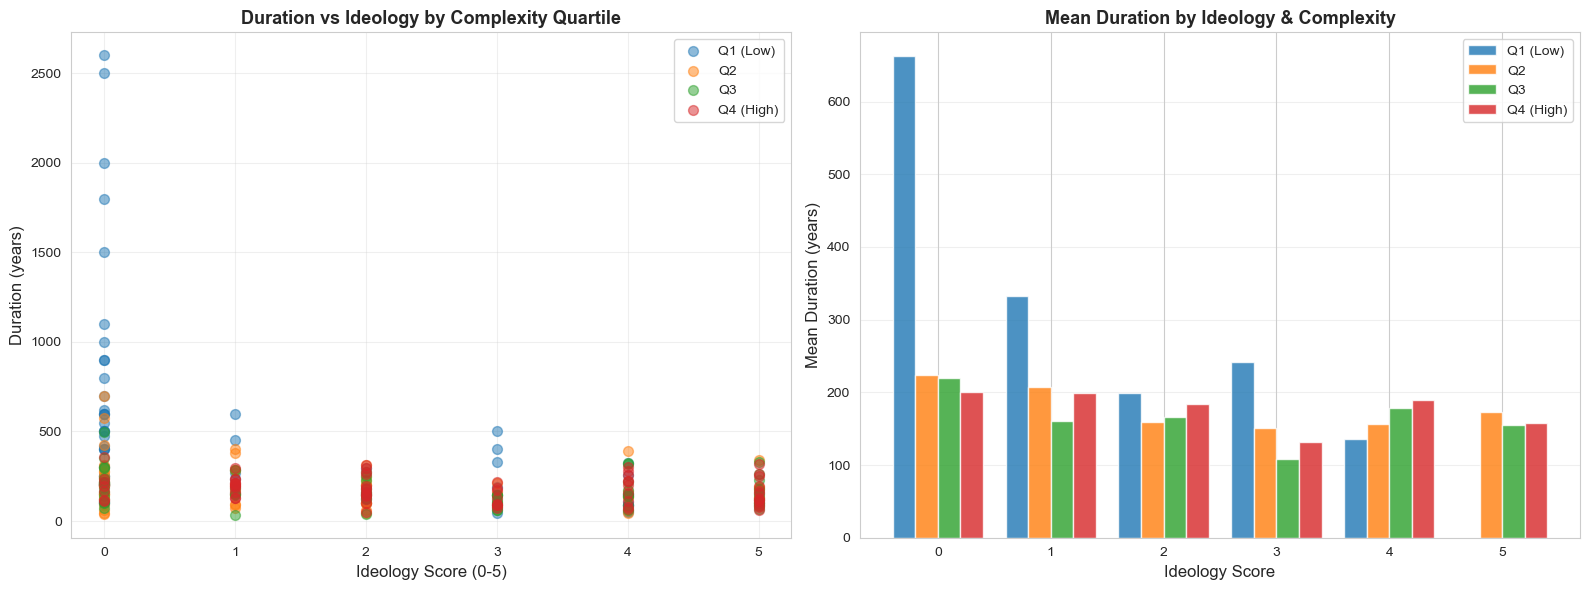

In [29]:
# TEST 7: Visualization - Ideology Effect by Complexity Quartiles

print("\n" + "="*80)
print("TEST 7: VISUALIZATION")
print("="*80)

# Create complexity quartiles
df_rel['complexity_quartile'] = pd.qcut(df_rel['PC1_hier'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Duration by ideology score, colored by complexity quartile
for q in df_rel['complexity_quartile'].cat.categories:
    q_data = df_rel[df_rel['complexity_quartile'] == q]
    axes[0].scatter(q_data['ideol_score'], q_data['duration_years'], 
                   alpha=0.5, s=50, label=q)

axes[0].set_xlabel('Ideology Score (0-5)', fontsize=12)
axes[0].set_ylabel('Duration (years)', fontsize=12)
axes[0].set_title('Duration vs Ideology by Complexity Quartile', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Mean duration by ideology level (0-5) and complexity quartile
ideol_levels = sorted(df_rel['ideol_score'].unique())
complexity_qs = df_rel['complexity_quartile'].cat.categories

x = np.arange(len(ideol_levels))
width = 0.2

for i, q in enumerate(complexity_qs):
    means = []
    for ideol in ideol_levels:
        subset = df_rel[(df_rel['complexity_quartile'] == q) & (df_rel['ideol_score'] == ideol)]
        means.append(subset['duration_years'].mean() if len(subset) > 0 else 0)
    
    axes[1].bar(x + i*width, means, width, label=q, alpha=0.8)

axes[1].set_xlabel('Ideology Score', fontsize=12)
axes[1].set_ylabel('Mean Duration (years)', fontsize=12)
axes[1].set_title('Mean Duration by Ideology & Complexity', fontsize=13, fontweight='bold')
axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels([f'{int(i)}' for i in ideol_levels])
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/06_ideology_complexity_interaction.png', dpi=300, bbox_inches='tight')
plt.show()
